# Amplitudes for EEW algorithms in SeisComP3

## Yannik Behr, Maren Böse, Men-Andrin Meier, John Clinton

### July 2015

Table of contents:

[How to edit this document](#howto)  
[General processing](#gp)  
[Gutenberg algorithm processing](#gba)  
[VS and FinDer processing](#vsfnd)  
[Traditional Onsite magnitude processing](#tons)

In the following we outline the technical specifications for a SeisComP3 module that computes waveform derived amplitudes required as input for EEW algorithms (Virtual Seismologist, Finite Fault Rupture Detector, Gutenberg Algorithm). It extends the already existing *scenvelope* module by also providing output of a filterbank using vertical and horizontal velocity data streams following a P-wave detection. In addition estimates of $\tau_c$ and $P_d$ are provided following a P-wave detection and $\tau_p$ is provided continuously. Figure 1 outlines the processing scheme which will be described in more detail in the following sections.

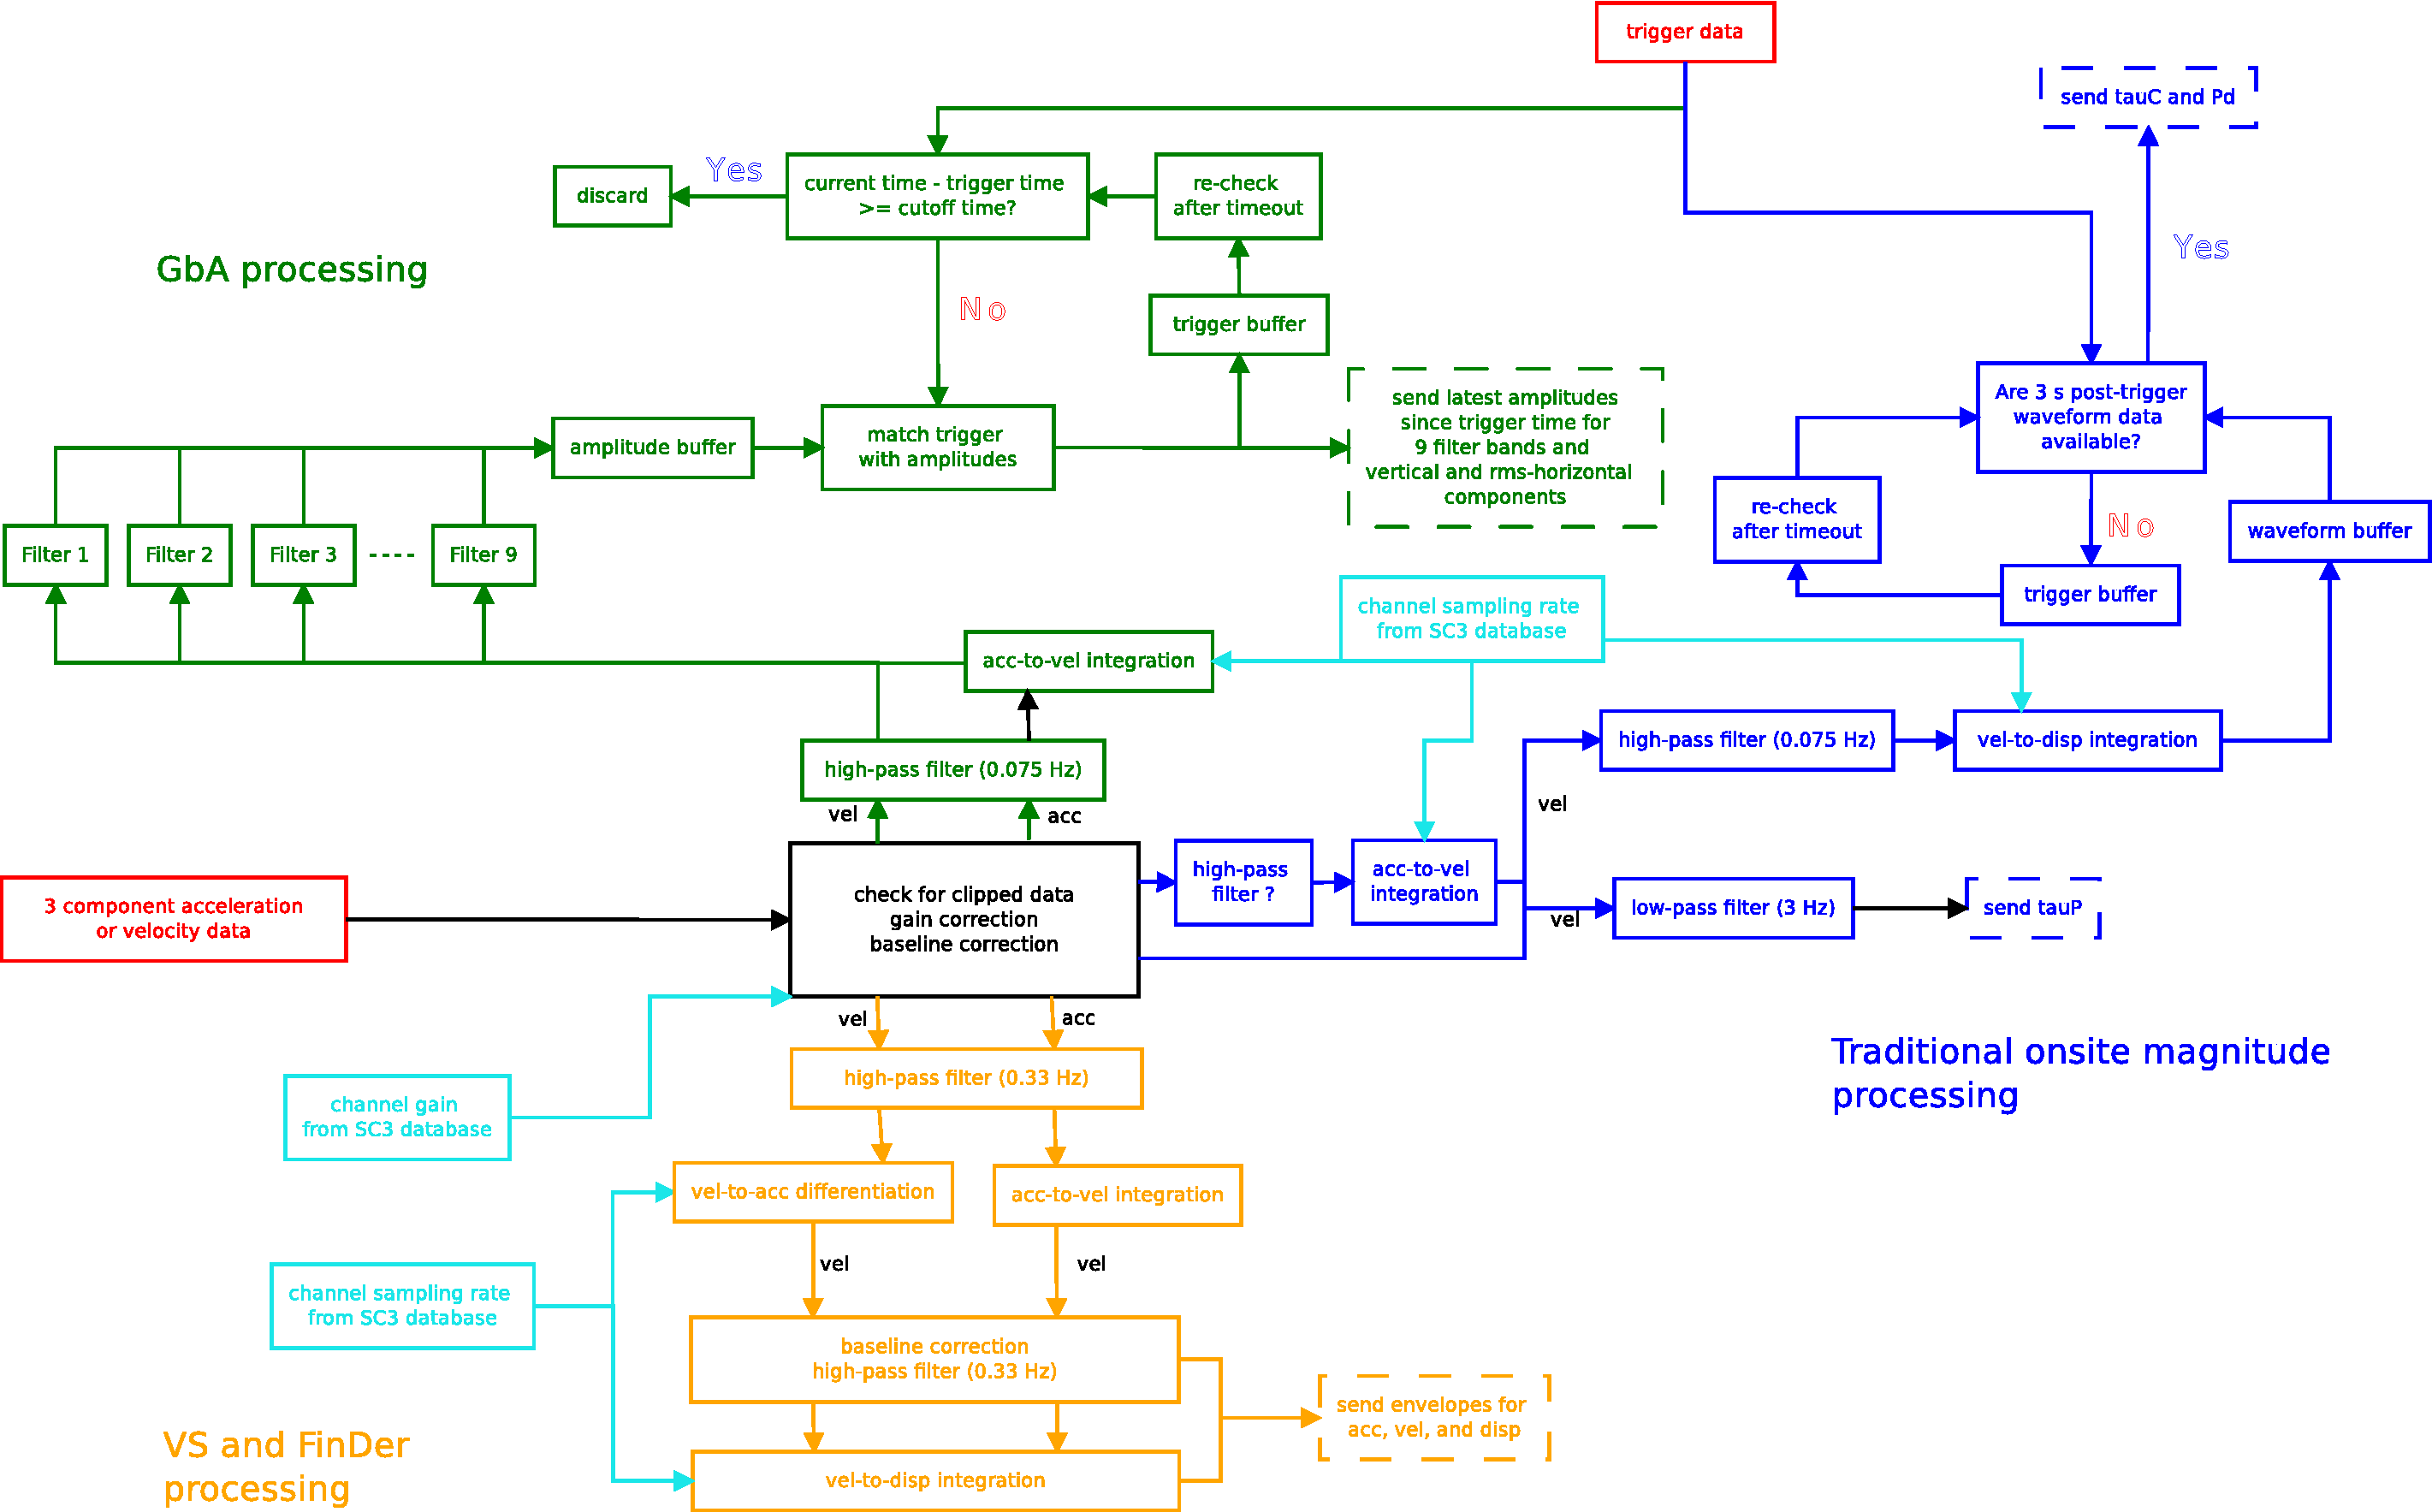

In [227]:
from IPython.display import Image
fpix = 'pix/eew_amplitudes.png'
Image(filename=fpix,retina=True)

**Figure 1**: Processing scheme for EEW amplitudes module. The processing specific to the Gutenberg Algorithm (GbA) is shown in green, to VS and FinDer in orange, and to traditional onsite magnitude estimators in blue. Red elements mark required input and elements with a dashed outline mark information that is send back to the system. The black box is common to all three processing strands.

<a id='gp'></a>
## General processing

### Waveform data
The envelope module retrieves velocity and/or acceleration data as MiniSEED records in real-time from a SeedLink server or from playbacks of archived data. The hostname and port of the SeedLink server is defined in the *global.cfg* file but it can be overwritten with the server configuration parameter using the same format used in *global.cfg*. For offline runs the path to a miniSEED record ~~or the URL of an arclink server~~ can be passed on the command line using the __–I__ option ~~(see scwfparam) together with the start- and end-time of the data window (using the command line options __–ts__ and __–te__)~~ [NOTE-YB: This feature has never been used because most other SC3 modules don't have it. I therefore suggest to remove it in the new version].
The list of requested channels is given with the following configuration parameters:

__streams.whitelist/streams.blacklist__: Defines the white- and blacklist of data streams to be used. The rules to decide if a stream is used or not are the following:
1. if whitelist is not empty and the stream is not on the whitelist, don't use it, ok otherwise
2. if blacklist is not empty and the stream is on the blacklist, don't use it, ok otherwise
Both checks are made and combined with AND. Either whitelist or blacklist contains a list of patterns (wildcard allowed as `*` and `?`), eg `GE.*.*.*, *, GE.MORC.*.BH?.` Each stream id (`NET.STA.LOC.CHA`) will be checked against the defined patterns.

### Sensor meta data
Meta data for each station is read at startup from the station inventory stored in the SeisComp3 database and kept in memory. The required information is the sampling rate and the stream gain for each channel. Points in the processing where at least parts of this information is required are marked with cyan arrows in Figure 1. The time for which the meta data is requested is the timestamp of the first MiniSEED package. That way the correct station meta data is requested during playbacks. 

### Clipped waveforms
The data-stream for every sensor and each of the E, N and Z components is processed separately as soon as new data packages arrive. First the incoming data streams are checked for clipped waveforms. A waveform stream is marked as clipped if the absolute amplitude exceeds X% of 2^23 assuming a 24-bit datalogger. X has a default value of 80 which can be changed through the configuration parameter __saturationThreshold__. (as done in scwfparam). If clipping is detected, messages based on this waveform package will be tagged as *clipped*. It is up to the receiving modules to handle messages which have been tagged as *clipped* (e.g. change from broadband to strong-motion streams for co-located sensors).

### Gain and baseline correction
After this first quality check the raw waveforms are corrected for the gain and baseline. For the baseline correction the average over the current data package is computed and then appended to a buffered 60 s average. The 60 s buffer is initialized with copies of the average computed over the first data package. Finally the 60 s average is subtracted from the data samples in the current data package. The length of the buffer in seconds can be configured using the configuration parameter __baselinecorrectionbuffer__.

<a id="gba"></a>
## Gutenberg Algorithm (GbA) processing

### Filtering
After the baseline correction follows a causal Butterworth high-pass filter with the corner frequency and the number of poles set to 0.075 Hz and 4 respectively. The filter is implemented as a fourth order recursive filter in the time domain using the bilinear transform to map the analogue filter characteristics onto the discrete domain. Filtering is done by applying a second-order Butterworth filter twice. To insure continuation across intervals the last four filter outputs of the previous interval are buffered (see also "VS and FinDer processing").

### Conversion from acceleration to displacement
Data streams from strong motion sensors are integrated to velocity. The integration is an implementation of the trapezoidal rule that either starts at the last integration result of the previous data package or at 0 if the current data package is the first (see also "VS and FinDer processing").

### Filterbank
Vertical and horizontal component velocity streams are filtered within 9 frequency bands using ?? pole Butterworth band-pass filters with the following corner frequencies:

| Band | low | high |
|------|-----|------|
|   1  |  24 |  48  |
|   2  |  12 |  24  |
|   3  |  6  |  12  |
|  ... |     |      |
|   9  |  0.09375  |  0.1875   |

This results in 27 continuous streams which are buffered for a configurable length using the configuration parameter __filterbank.bufferlength__.

### Trigger matching
Once a P-wave detection ("trigger") is received, the difference between current time and the trigger time is compared with the configurable cutoff time (configuration __filterbank.cutofftime__). If the time difference is less than the cutoff time, the latest filterbank values for all streams of the corresponding station are sent, otherwise the trigger is discarded. The trigger is written to a buffer and the latest filterbank values are checked and sent as soon as they become available until the time difference between current time and trigger time is equal or greater than the cutoff time. Once the cutoff time is reached, the trigger is removed from the trigger buffer.

### Logging

<a id="vsfnd"></a>
## VS and FinDer processing
All processing will happen on configurable time intervals which may be different to the package size. The current scenvelope module processes intervals of 1 s length. The new version will allow for configurable interval lengths through the configuration parameter __vsfndr.envelopeinterval__.

### Filtering
After the baseline correction follows a causal Butterworth high-pass filter with the corner frequency and the number of poles set to 0.333 Hz and 4 respectively. These parameters are not configurable since the envelope attenuation relationships used for VS and FinDer were derived for this filter configuration. The filter is implemented as a fourth order recursive filter in the time domain using the bilinear transform to map the analogue filter characteristics onto the discrete domain. Filtering is done by applying a second-order Butterworth filter twice. To insure continuation across intervals the last four filter outputs of the previous interval are buffered. [NOTE-YB: Compare SC3 filter implementation with that used in VS(EW) and then decide which implementation to use. In the previous version we kept the option to use either or, but I think this is overkill.]

### Conversion to acceleration/velocity/displacement
If the input trace is velocity it is differentiated to acceleration. If the input trace is acceleration it is integrated to velocity which has subsequently its mean removed and the high pass filter applied. The velocity trace will then be integrated to displacement. The differentiation is a finite difference that uses the last differentiation result of the previous processing interval as the starting point. The first finite difference of the first interval starts at zero. 
The integration is an implementation of the trapezoidal rule that either starts at the last integration result of the previous interval or at 0 if the current interval is the first. 




#### Integration

In [2]:
%matplotlib notebook
#%pylab # commented because it doesn't work for headless notebook servers
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class cumtrapz:
    """
    Cumulative trapezoid rule which implicitly 
    connects measurements with a straight line.
    """
    def __init__(self,dt):
        self.fac = dt/2.0
        self.prev_in = 0.0
        self.prev_out = 0.0
        
    def integrate(self,data):
        n = data.size
        out = np.zeros(n)
        if abs(self.prev_in) < 1e-6:
            out[0] = 0.0
        else:
            out[0] = self.prev_out + (data[0]+self.prev_in)*self.fac
        
        for i in xrange(1,n):
            out[i] = out[i-1] + (data[i] + data[i-1])*self.fac
        
        self.prev_in = data[n-1]
        self.prev_out = out[n-1]
        
        return out

##### Testing
In the following test we integrate a sine wave over two cycles and evaluate the errror. The sine wave is further cut into smaller chunks to simulate real-time behavious.

<IPython.core.display.Javascript object>


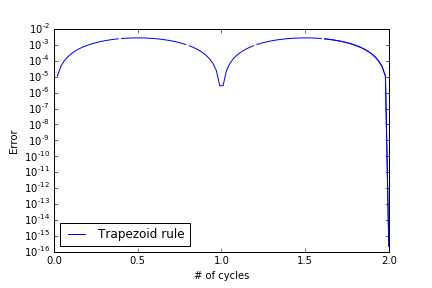

In [8]:
f = lambda x: np.sin(x)
f_true = lambda x: -np.cos(x)+1.0
ns = 100
pi2 = 2.0*np.pi
x = np.linspace(0,4*np.pi,ns)
dx = np.mean(np.diff(x))
step = 20
start = 0
end = step
valst = []
valss = []
t = cumtrapz(dx)
while end <= ns:
    x1 = x[start:end]
    y1 = f(x1)
    Yt = t.integrate(y1)
    plt.semilogy(x1/pi2,abs(f_true(x1)-np.array(Yt)),'b-')
    start = end
    end += step
plt.semilogy(x1/pi2,abs(f_true(x1)-np.array(Yt)),'b-',label='Trapezoid rule')
plt.legend(loc='lower left')
plt.ylabel('Error')
plt.xlabel('# of cycles')

#### Differentiation

In [5]:
class onesided:
    """
    This differentiation method assumes measurements
    are connected through straight lines and has an 
    accuracy of O(h).
    """
    def __init__(self,dx):
        self.prev_val = 0.0
        self.dx = dx
    
    def differentiate(self,data):
        n = data.size
        out = np.zeros(n)
        if abs(self.prev_val) < 1e-6:
            out[0] = 0.0
        else:
            out[0] = (data[0] - self.prev_val)/self.dx

        for i in xrange(1,n):
            out[i] = (data[i] - data[i-1])/self.dx
        
        self.prev_val = data[n-1]
        return out

In [6]:
class central:
    """
    This differentiation method assumes measurements
    are connected through 2nd order polynomials and has an 
    accuracy of O(h^2).
    """
    def __init__(self,dx):
        self.prev_val = 0.0
        self.fac = 1.0/(2.0*dx)
    
    def differentiate(self,data):
        n = data.size
        out = np.zeros(n)
        if abs(self.prev_val) < 1e-6:
            out[0] = self.fac*(-3.0*data[0]+4.0*data[1]-data[2])
        else:
            out[0] = self.fac*(data[1] - self.prev_val)
                            
        for i in xrange(1,n-1):
            out[i] = self.fac*(data[i+1] - data[i-1])
        
        out[n-1] = self.fac*(data[n-3] - 4.0*data[n-2] + 3.0*data[n-1])
        self.prev_val = data[n-1]
        return out

##### Testing
The same test as for the previous integration part but this time a cosine wave is differentiated. Note the higher accuracy of the central differential quotient.

<IPython.core.display.Javascript object>


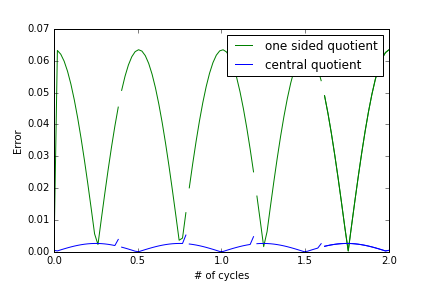

In [9]:
f = lambda x: np.cos(x)
f_true = lambda x: -np.sin(x)
ns = 100
x = np.linspace(0,4*np.pi,ns)
dx = np.mean(np.diff(x))
pi2 = 2.0*np.pi
step = 20
start = 0
end = step
o = onesided(dx)
c = central(dx)
while end <= ns:
    x1 = x[start:end]
    y1 = f(x1)
    Yo = o.differentiate(y1)
    Yc = c.differentiate(y1)
    plt.plot(x1/pi2,abs(f_true(x1)-np.array(Yo)),'g-')
    plt.plot(x1/pi2,abs(f_true(x1)-np.array(Yc)),'b-')
    start = end
    end += step
plt.plot(x1/pi2,abs(f_true(x1)-np.array(Yo)),'g-',label='one sided quotient')
plt.plot(x1/pi2,abs(f_true(x1)-np.array(Yc)),'b-',label='central quotient')
plt.legend()
plt.xlabel('# of cycles')
plt.ylabel('Error')

Testing with real data by comparing time series from a broad-band sensor and a co-located strong motion sensor. 

/Users/fmassin/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/fmassin/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/fmassin/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/fmassin/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/fmassin/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number 

<IPython.core.display.Javascript object>


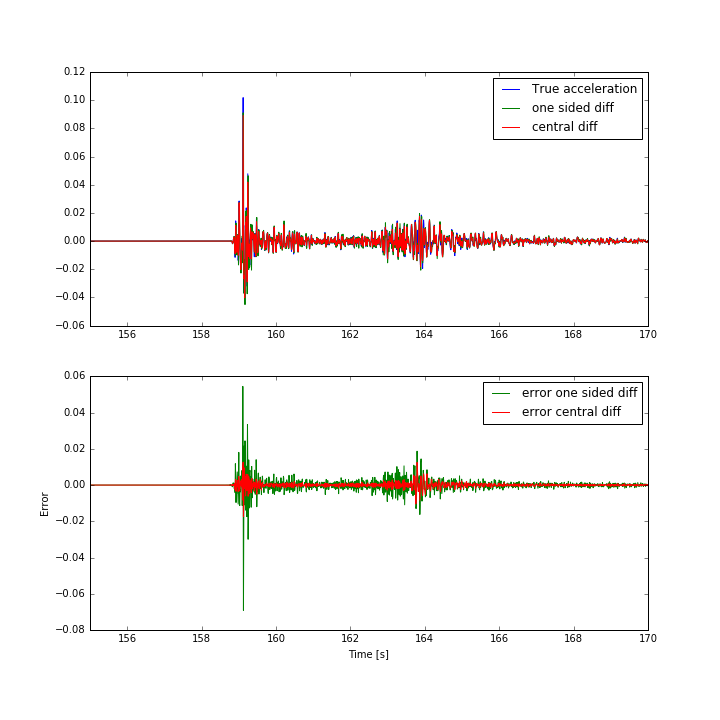

Least squares error for onesided is: 0.155442
Least squares error for central is: 0.056725


In [12]:
from obspy import read
# Load and pre-process the raw data
fin = './zur.mseed'
hg_gain = 407879.0
hh_gain = 600000000.0
st = read(fin)
acc = st.select(channel='HGZ')[0]
vel = st.select(channel='HHZ')[0]
dt = acc.stats.delta
vel.data = vel.data.astype(float) / hh_gain
acc.data = acc.data.astype(float) / hg_gain
acc.data -= acc.data.mean()
vel.data -= vel.data.mean()

# Compute the derivative of the velocity trace
o = onesided(vel.stats.delta)
c = central(vel.stats.delta)
step = 20*vel.stats.sampling_rate
start = 0
end = step
acc1 = np.zeros(vel.stats.npts)
acc2 = np.zeros(vel.stats.npts)
while True:
    _v = vel.data[start:end]
    acc1[start:end] = o.differentiate(_v)
    acc2[start:end] = c.differentiate(_v)
    start = end
    end += step
    if end >= vel.stats.npts-3:
        end = vel.stats.npts-3
        _v = vel.data[start:end]
        acc1[start:end] = o.differentiate(_v)
        acc2[start:end] = c.differentiate(_v)
        break
        
# Compare the derivative of the velocity trace with 
# the data from the co-located strong motion sensor
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
idx0 = int((acc.stats.starttime - vel.stats.starttime)*vel.stats.sampling_rate)
vtimes = vel.times() - vel.times()[idx0]
idxend = min(vel.stats.npts-idx0,acc.stats.npts)
ax1.plot(acc.times(), acc.data,label='True acceleration')
ax1.plot(vtimes,acc1,label='one sided diff')
ax1.plot(vtimes,acc2, label='central diff')
ax1.legend(loc='upper right')
ax1.set_xlim(155,170)
ax2 = fig.add_subplot(2,1,2)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude [m/s/s]')
ax2.plot(vtimes[idx0:idxend+idx0], acc.data[0:idxend]-acc1[idx0:idxend+idx0],'g',label='error one sided diff')
ax2.plot(vtimes[idx0:idxend+idx0], acc.data[0:idxend]-acc2[idx0:idxend+idx0],'r', label='error central diff')
ax2.legend(loc='upper right')
ax2.set_xlim(155,170)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Error')
lserror1 = np.sqrt(sum((acc.data[0:idxend]-acc1[idx0:idxend+idx0])**2))
lserror2 = np.sqrt(sum((acc.data[0:idxend]-acc2[idx0:idxend+idx0])**2))
print "Least squares error for onesided is: %f" %lserror1
print "Least squares error for central is: %f" %lserror2


### Conversion to envelope values
Envelope values are then computed by taking the maximum absolute value within the  interval. The envelope values for the 3 components of acceleration, velocity and displacement are sent with the corresponding timestamps via scmaster to the VS module. All integration and differentiation steps also require information on the sampling rate. Picking, as done in the original Earthworm based VS waveform processing system, is not required since the VS module uses origins and corresponding picks reported by scautoloc.

### Logging

<a id="tons"></a>
## Traditional onsite magnitude processing
### Conversion from acceleration to velocity
This will be done in the same way as described in Section "VS and FinDer processing".


## $\tau_p$
Before calculating $\tau_p$ a lowpass filter at 3 Hz is applied. [NOTE-YB: From publications it is not clear what kind of filter is applied here. I'd therefore suggest to also apply a 2nd order Butterworth filter twice to get a 4th order filter]. Afterwards the $\tau_p$ equation is applied to an interval whose length is configurable through the configuration parameter __taupinterval__ (default 0.5 s) and the $\tau_p$ value is sent [NOTE-YB: This is following the processing of Elarms which also creates a stream of $\tau_p$ values that are then evaluated by a second module. However, one could also trigger $\tau_p$ calculations with the detection of a P-wave as suggested for $\tau_c$ and $P_d$ with the advantage that less data has to be sent continuously].

In [13]:
def taup(x,sps):
    """
    Implementation of the taup algorithm.
    x = velocity time series
    sps = sampling frequency
    """
    tp = np.zeros(x.size)
    dt = 1.0/sps
    x_old = x[1]**2
    d_old = ((x[1] - x[0])/dt)**2
    alpha = 1.0-1.0/sps
    for i in range(2,x.size):
        D = alpha*d_old + ((x[i] - x[i-1])/dt)**2
        d_old = D
        X = alpha*x_old + x[i]**2
        x_old = X
        tp[i] = 2*np.pi*np.sqrt(X/D)
    return tp


#### Testing $\tau_p$

Generating a test signal

In [14]:
# Sampling rate = 100 Hz
sps = 100
# Length of the signal = 5 s
t = np.arange(0,5,1.0/sps)
# 3 different frequencies, amplitudes, and phases
# f1 is the dominant frequency
f1 = 10; f2 = 20; f3 = 30
phi1 = np.pi/2; phi2 = np.pi/8.; phi3 = np.pi/4
a1 = 20; a2 = 2; a3 = .2
s1 = a1*np.sin(2*np.pi*f1*t+phi1)
s2 = a2*np.sin(2*np.pi*f2*t+phi2)
s3 = a3*np.sin(2*np.pi*f3*t+phi3)
s = s1+s2+s3

Computing $\tau_p$:

In [15]:
tp = taup(s,sps)
print "Mean of taup: %.2f" % tp.mean()
print "Dominant period: %.2f" % (1.0/f1)

Mean of taup: 0.10
Dominant period: 0.10


Plotting the results:

<IPython.core.display.Javascript object>


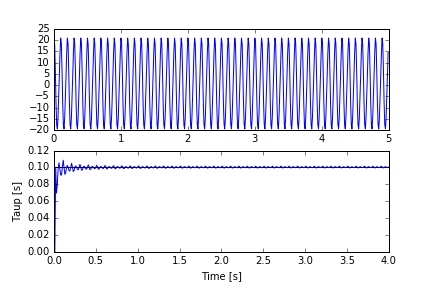

In [16]:
# Test
plt.subplot(2,1,1)
plt.plot(t,s)
plt.xlim(0,5)
plt.subplot(2,1,2)
plt.plot(t,tp)
plt.hlines(1.0/f1,0,10)
plt.xlim(0,4)
ymin, ymax = plt.ylim()
if ymax <= 1.0/f1:
    ymax = 1.0/f1 + 0.2*(1.0/f1)
plt.ylim(ymin,ymax)
plt.ylabel("Taup [s]")
plt.xlabel("Time [s]")

#### References
Allen, R. M., and H. Kanamori (2003), The potential for earthquake early warning in southern California, Science, 300, 786–789.

Olson, E. L., and R. M. Allen (2005), The deterministic nature of earthquake rupture., Nature, 438(7065), 212–5, doi:10.1038/nature04214.

Nakamura, Y. (1988), On the Urgent Earthquake Detection and Alarm System (UrEDAS), in Proceedings of Ninth World Conference on Earthquake Engineering, Tokyo-Kyoto, Japan.

## $\tau_c$ and $P_d$

Before calculating $\tau_c$ and $P_d$ a high-pass 2nd order butterworth filter at 0.075 Hz is applied. [Satriano et al., 2011]. Afterwards velocities are integrated to displacement [NOTE-YB: Satriano et al., 2011 suggest to use the high-pass filter after integration to remove the trend from the integration]. If a P-wave detection is received and 3 s of post-pick waveforms are available the values for $\tau_c$ and $P_d$ are computed and sent as amplitudes with references to the corresponding P-wave detection. If not enough waveform data is available, the waveform buffer is rechecked in 0.5 s intervals.  

In [18]:
def tauc_Pd(vel,disp,pick,sps,tau0=3):
    """
    Returns the tau_c and Pd values for a given
    time window.
    vel = velocity time series
    disp = displacement time series
    pick = P-wave detection time
    sps = sampling frequency
    tau0 = evaluation window
    """
    dt = 1.0/sps
    start = pick*sps
    end = tau0*sps
    ct1 = cumtrapz(dt)
    ct2 = cumtrapz(dt)
    r_1      = ct1.integrate(vel[start:(end+1)]**2)
    r_2      = ct2.integrate(disp[start:(end+1)]**2)
    r        = r_1[-1]/r_2[-1]
    return (2*np.pi/np.sqrt(r), abs(disp[start:(end+1)]).max())

#### Testing $\tau_c$

Generating a test signal

In [19]:
# Sampling rate = 100 Hz
sps = 100
# Length of the signal = 5 s
t = np.arange(0,5,1.0/sps)
# 3 different frequencies, amplitudes, and phases
# f1 is the dominant frequency
f1 = 0.5; f2 = 10; f3 = 30
phi1 = np.pi/2; phi2 = np.pi/8.; phi3 = np.pi/4
a1 = 20; a2 = 2; a3 = .2
s1 = a1*np.sin(2*np.pi*f1*t+phi1)
s2 = a2*np.sin(2*np.pi*f2*t+phi2)
s3 = a3*np.sin(2*np.pi*f3*t+phi3)
vel = s1+s2+s3
cs = cumtrapz(1.0/sps)
disp = cs.integrate(vel)

Computing $\tau_c$

In [20]:
tc,pd = tauc_Pd(vel,disp,0,sps,tau0=3)
print "Value of tau_c: %.2f; Value of P_d: %.2f" % (tc,pd)
print "Dominant period: %.2f" % (1.0/f1)

Value of tau_c: 1.99; Value of P_d: 6.39
Dominant period: 2.00


#### References
Kanamori, H. (2005), Real-Time Seismology and Earthquake Damage Mitigation, Annu. Rev. Earth Planet. Sci., 33(1), 195–214, doi:10.1146/annurev.earth.33.092203.122626.

Satriano, C., Y.-M. Wu, A. Zollo, and H. Kanamori (2011), Earthquake early warning: Concepts, methods and physical grounds, Soil Dyn. Earthq. Eng., 31(2), 106–118, doi:10.1016/j.soildyn.2010.07.007.


<a id='howto'></a>
## How to edit this document
Unfortunately, Ipython notebooks have no "track changes" functionality. I would therefore suggest that you comment and start every new comment with "[NOTE-YourInitials]" for example I added comments with [NOTE-YB]. If you want to edit text just double-click on it. It will then display the text in markdown, the formatting language used here. You can find a quick guide to markdown [here](https://help.github.com/articles/markdown-basics/). After finishing your edits run Shift-Enter to execute the cell (i.e. convert markdown to HTML or execute a code cell).  
Don't forget to save your changes with Ctrl-s or by pressing the 'save' button. The **+** button lets you insert a new cell below the current one which you then can format as either a markdown cell or a code cell using the first drop-down menu.